In [1]:
import numpy as np
import torch.nn as nn

import torchvision
import torchvision.transforms as t

from torch.utils.data import DataLoader, Dataset

from scipy.signal import convolve2d

from imageio.v3 import imread

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Creating a Image and Kernel

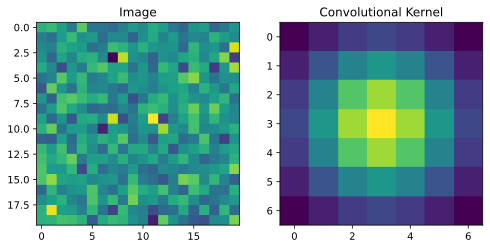

In [2]:
img_number = 20

image = np.random.randn(img_number, img_number)

kernel_length = 7
y, x = np.meshgrid(np.linspace(-3, 3, kernel_length), np.linspace(-3, 3, kernel_length))
kernel = np.exp(-(x**2+y**2)/7)

_, axis = plt.subplots(1, 2, figsize=(8, 6))
axis[0].imshow(image)
axis[0].set_title("Image")

axis[1].imshow(kernel)
axis[1].set_title("Convolutional Kernel");

# Applying the Kernel on the Image Manually

In [3]:
convo_output_1 = np.zeros((img_number, img_number))

half_kernel = kernel_length//2

for i in range(half_kernel, img_number-half_kernel):
    for j in range(half_kernel, img_number-half_kernel):
        
        piece_of_image = image[i-half_kernel:i+half_kernel+1, :]
        piece_of_image = piece_of_image[:, j-half_kernel:j+half_kernel+1]
        
        dot_product = np.sum(piece_of_image*kernel[::-1, ::-1])
        
        convo_output_1[i, j] = dot_product

# Applying the Kernel on the Image Automatic

In [4]:
convo_output_2 = convolve2d(image, kernel, mode="valid")

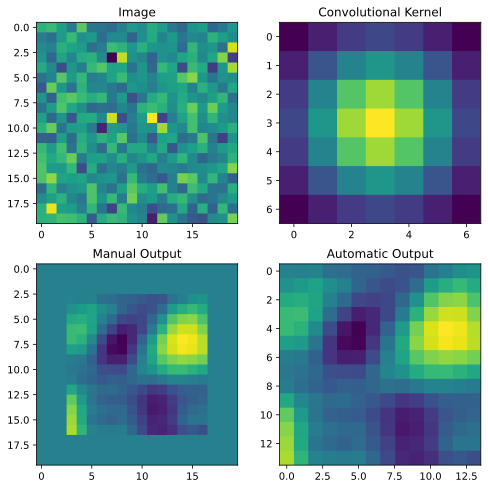

In [5]:
_, axis = plt.subplots(2, 2, figsize=(8, 8))

axis[0, 0].imshow(image)
axis[0, 0].set_title("Image")

axis[0, 1].imshow(kernel)
axis[0, 1].set_title("Convolutional Kernel")

axis[1, 0].imshow(convo_output_1)
axis[1, 0].set_title("Manual Output")

axis[1, 1].imshow(convo_output_2)
axis[1, 1].set_title("Automatic Output");

# Applying the kernel on the Image via the PyTorch

(1675, 3000, 3)
(1675, 3000)


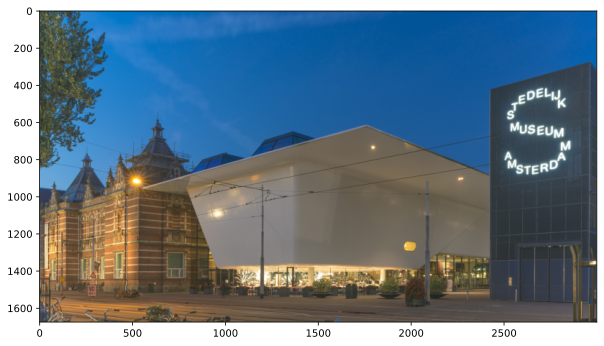

In [6]:
real_image = imread("https://upload.wikimedia.org/wikipedia/commons/6/61/De_nieuwe_vleugel_van_het_Stedelijk_Museum_Amsterdam.jpg")

print(real_image.shape)

_ = plt.figure(figsize=(10, 6))
plt.imshow(real_image)

real_image = np.mean(real_image, axis=2)
real_image = real_image/np.max(real_image)

print(real_image.shape)

In [7]:
vertical_kernel = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

horizontal_kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

In [8]:
_, axis = plt.subplots(2, 2, figsize=(16, 8))

axis[0, 0].imshow(vertical_kernel)
axis[0, 0].set_title("Vertical Kernel")

axis[0, 1].imshow(horizontal_kernel)
axis[0, 1].set_title("Horizontal Kernel")

axis[1, 0].imshow(convolve2d(real_image, vertical_kernel, mode="valid"), cmap="gray", vmin=0, vmax=0.1)
axis[1, 0].set_title("Applying Vertical Kernel")

axis[1, 1].imshow(convolve2d(real_image, horizontal_kernel, mode="valid"), cmap="gray", vmin=0, vmax=0.1)
axis[1, 1].set_title("Applying Horizontal Kernel");

In [9]:
import torch
import torch.nn.functional as f

vk_t = torch.DoubleTensor(vertical_kernel).view(1, 1, 3, 3)
hk_t = torch.DoubleTensor(horizontal_kernel).view(1, 1, 3, 3)

real_image_t = torch.tensor(real_image).view(1, 1, real_image.shape[0], real_image.shape[1])

print(vk_t.shape)
print(real_image_t.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 1675, 3000])


In [10]:
convo_tensor = f.conv2d(real_image_t, vk_t)
print(convo_tensor.shape)

torch.Size([1, 1, 1673, 2998])


In [11]:
_, axis = plt.subplots(2, 2, figsize=(16, 8))

axis[0, 0].imshow(vertical_kernel)
axis[0, 0].set_title("Vertical Kernel")


axis[0, 1].imshow(horizontal_kernel)
axis[0, 1].set_title("Horizontal Kernel")

axis[1, 0].imshow(torch.squeeze(f.conv2d(real_image_t, vk_t)), cmap="gray", vmin=0, vmax=0.1)
axis[1, 0].set_title("Applying Vertical Kernel")

axis[1, 1].imshow(torch.squeeze(f.conv2d(real_image_t, hk_t)), cmap="gray", vmin=0, vmax=0.1)
axis[1, 1].set_title("Applying Horizontal Kernel");

# Creating the convolution class instance with parameters and seeing those filters

In [12]:
in_channels = 3
out_channels = 15
kernel_size = 5
stride = 1
padding = 0

convo = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

print(convo)

print("Size of weights :", str(convo.weight.shape))
print("Size of bias :", str(convo.bias.shape))

Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
Size of weights : torch.Size([15, 3, 5, 5])
Size of bias : torch.Size([15])


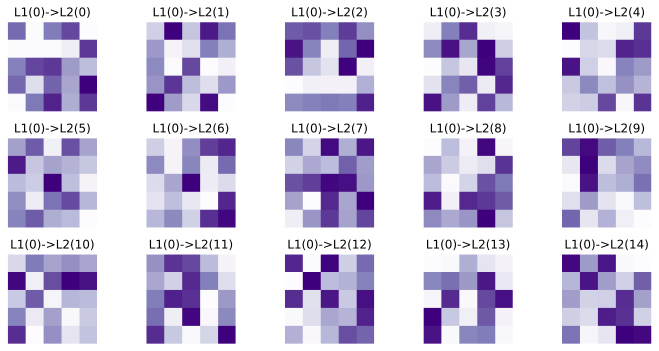

In [13]:
_, axis = plt.subplots(3, 5, figsize=(10, 5))

for i, ax in enumerate(axis.flatten()):
    ax.imshow(torch.squeeze(convo.weight[i, 0, :, :]).detach(), cmap="Purples")
    ax.set_title("L1(0)->L2(%s)"%i)
    ax.axis("off")

plt.tight_layout();

# Creating the image with torch and show that with plt format

In [14]:
image_size = (1, 3, 64, 64)

image = torch.randn(image_size)

image_view = image.permute(2, 3, 1, 0).numpy()

print(image.shape)
print(image_view.shape)

plt.imshow(np.squeeze(image_view));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


# Convolving the image and seeing the output

In [15]:
convo_image = convo(image)

print(convo_image.shape)
print(image.shape)

torch.Size([1, 15, 60, 60])
torch.Size([1, 3, 64, 64])


In [16]:
_, axis = plt.subplots(3, 5, figsize=(10, 5))

for i, ax in enumerate(axis.flatten()):
    ax.imshow(torch.squeeze(convo_image[0, i, :, :]).detach(), cmap="Purples")
    ax.set_title("Conv. w/ filter %s"%i)
    ax.axis("off")

plt.tight_layout();

# Convolving an image of size 3x64x64 to produce a 10x28x28

In [17]:
in_channels = 3
image_size = [64, 64]
out_channels = 10
kernel_size = 9
stride = 2
padding = 0

convo = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

image = torch.randn(1, in_channels, image_size[0], image_size[1])

convo_image = convo(image)
empirical_size = torch.squeeze(convo_image).shape

expect_size = np.array([out_channels, 0, 0], dtype=int)
expect_size[1] = np.floor((image_size[0]+2*padding-kernel_size)/stride)+1
expect_size[2] = np.floor((image_size[1]+2*padding-kernel_size)/stride)+1

print(f"Expected Size :", expect_size)
print(f"Empirical Size :", list(empirical_size))

Expected Size : [10 28 28]
Empirical Size : [10, 28, 28]


# Creating the Transposition of the Convolution Class Instance

In [18]:
in_channels = 3
out_channels = 15
kernel_size = 5
stride = 1
padding = 0

convo_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)

print(convo_transpose)

print("Size of weights :", str(convo_transpose.weight.shape))
print("Size of bias :", str(convo_transpose.bias.shape))

ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
Size of weights : torch.Size([3, 15, 5, 5])
Size of bias : torch.Size([15])


# Showing the filters

In [19]:
_, axis = plt.subplots(3, 5, figsize=(10, 5))

for i, ax in enumerate(axis.flatten()):
    ax.imshow(torch.squeeze(convo_transpose.weight[0, i, :, :]).detach(), cmap="Purples")
    ax.set_title("L1(0)->L2(%s)"%i)
    ax.axis("off")

plt.tight_layout();

# Creating the Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


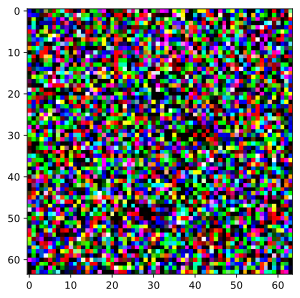

In [20]:
image_size = (1, 3, 64, 64)

image = torch.randn(image_size)

image_view = image.permute(2, 3, 1, 0).numpy()

print(image.shape)
print(image_view.shape)

plt.imshow(np.squeeze(image_view));

# Applying the Transpose Convolution on the Image

In [21]:
convo_image = convo_transpose(image)

print(convo_image.shape)
print(image.shape)

torch.Size([1, 15, 68, 68])
torch.Size([1, 3, 64, 64])


# All the filters in the Image

In [22]:
_, axis = plt.subplots(3, 5, figsize=(10, 5))

for i, ax in enumerate(axis.flatten()):
    ax.imshow(torch.squeeze(convo_image[0, i, :, :]).detach(), cmap="Purples")
    ax.set_title("Conv. w/ filter %s"%i)
    ax.axis("off")

plt.tight_layout();

# Creating a Class Instance of Max Pool 2D and 3D 

In [23]:
pool_size = 3
stride = 3

pool_2 = nn.MaxPool2d(pool_size, stride)
pool_3 = nn.MaxPool3d(pool_size, stride)

print(pool_2)
print(pool_3)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


# Applying the Pooling on 2D and 3D Image

In [24]:
image_2 = torch.randn(1, 1, 30, 30)
image_3 = torch.randn(1, 3, 30, 30)

image_2_pool_2 = pool_2(image_2)
print(f"2D Image, 2D Max Pool : {image_2_pool_2.shape}")

image_3_pool_2 = pool_2(image_3)
print(f"3D Image, 2D Max Pool : {image_3_pool_2.shape}")

image_3_pool_3 = pool_3(image_3)
print(f"3D Image, 3D Max Pool : {image_3_pool_3.shape}")

2D Image, 2D Max Pool : torch.Size([1, 1, 10, 10])
3D Image, 2D Max Pool : torch.Size([1, 3, 10, 10])
3D Image, 3D Max Pool : torch.Size([1, 1, 10, 10])


# Creating a Model with Convolution, Average Pooling

In [25]:
model = nn.Sequential(nn.Conv2d(3, 10, 5, 3, 2), nn.ReLU(), nn.AvgPool3d(3, 3), nn.Flatten(), nn.Linear(588, 1), nn.Sigmoid())

# Applying the Model on the Image

In [26]:
image = torch.rand(1, 3, 128, 128)
model(image)

tensor([[0.5304]], grad_fn=<SigmoidBackward0>)

# Downloading the CIFAR10 Dataset

In [27]:
cifar_data = torchvision.datasets.CIFAR10(root="cifar10", download=True)

print(cifar_data)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train


# Explaining the Data

In [28]:
print(cifar_data.data.shape)

print(cifar_data.classes)

print(len(cifar_data.targets))

(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
50000


# Showing the Images

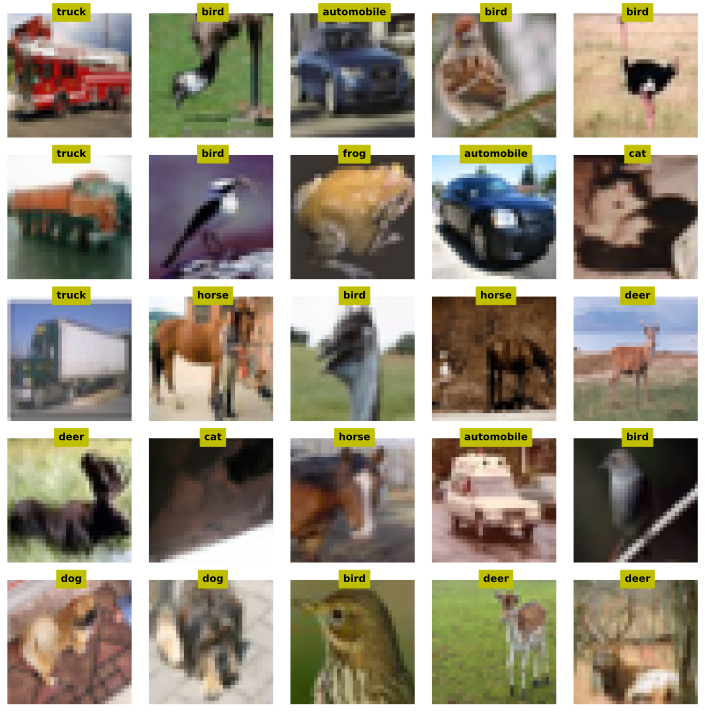

In [29]:
_, axis = plt.subplots(5, 5, figsize=(10, 10))

for ax in axis.flatten():
    rand_ind = np.random.choice(len(cifar_data.targets))
    
    image = cifar_data.data[rand_ind, :, :, :]
    
    label = cifar_data.classes[cifar_data.targets[rand_ind]]
    
    ax.imshow(image)
    ax.text(16, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y")
    ax.axis("off")

plt.tight_layout();

# Defining the Transformations

In [30]:
transforms = t.Compose([t.ToTensor(), t.Resize(32*4), t.Grayscale(num_output_channels=1)])

cifar_data.transforms = transforms

print(cifar_data.data[123, :, :, :].shape)

(32, 32, 3)


# Applying the Transformations on the CIFAR10

C:\Users\drkum\DataspellProjects\deep_learning_pytorch\venv\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


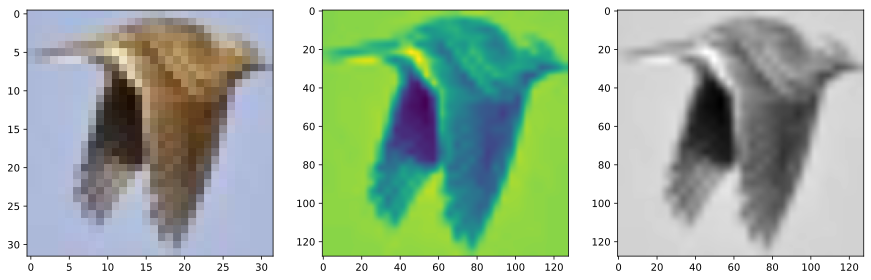

In [31]:
image_1 = transforms(cifar_data.data[123, :, :, :])

image_2 = cifar_data.transforms(cifar_data.data[123, :, :, :])

_, axis = plt.subplots(1, 3, figsize=(15, 10))
axis[0].imshow(cifar_data.data[123, :, :, :])
axis[1].imshow(torch.squeeze(image_1))
axis[2].imshow(torch.squeeze(image_2), cmap="gray")

plt.show()

# Working on the MNIST Data

In [32]:
data = np.loadtxt(open("mnist_train_small.csv", "rb"), delimiter=",")

labels = data[:8, 0]
data = data[:8, 1:]

data_norm = data / np.max(data)

data_norm = data_norm.reshape(data_norm.shape[0], 1, 28, 28)

print(data_norm.shape)
print(labels.shape)

data_tensor = torch.FloatTensor(data_norm)
labels_tensor = torch.LongTensor(labels)

(8, 1, 28, 28)
(8,)


# Creating the Custom Dataset Class

In [33]:
class customDataset(Dataset):
    def __init__(self, tensors, transform=None):
        
        assert all(tensors[0].size(0) == t.size(0) for t in tensors), "Size mismatch between tensors"
        
        self.tensors = tensors
        self.transform  = transform
        
    def __getitem__(self, index):
        
        if self.transform:
            x = self.transform(self.tensors[0][index])
        else:
            x = self.tensors[0][index]
        
        y = self.tensors[1][index]
        
        return x, y
    
    def __len__(self):
        return self.tensors[0].size(0)

# Creating the Transformations 

In [34]:
image_trains = t.Compose([t.ToPILImage(), t.RandomVerticalFlip(p=0.5), t.ToTensor()])

In [35]:
train_data = customDataset((data_tensor, labels_tensor), image_trains)

data_loaded = DataLoader(train_data, batch_size=8, shuffle=False)

In [36]:
type(train_data)

__main__.customDataset

In [37]:
x, y = next(iter(data_loaded))

_, axis = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    axis[0, i].imshow(data_tensor[i, 0, :, :].detach(), cmap="gray")
    axis[1, i].imshow(x[i, 0, :, :].detach(), cmap="gray")
    
    for row in range(2):
        axis[row, i].set_xticks([])
        axis[row, i].set_yticks([])
        
axis[0, 0].set_ylabel("Original")
axis[1, 0].set_ylabel("Torch Dataset");